# Instrumental variables

Identify instrumental variable

Perform 2 stages least squares, 2SLS
1. Regression where outcome is treatment, and predictors are the instrumental variable and then any measured confounders you want to include
2. Regression where outcome is the outcome, and predictors are the fitted values (i.e. treatment with no omitted variable bias) from the first model, and then your measured confounders again.

<mark>why do you have to include those confoudners both times?</mark>
* Included in first stage to reflect exogenous movement in treatment
* Included in second stage to avoid omitted variable bias

## Python example

This example is taken from [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) (MIT license).

Interested in causal effect of education on wage. Confounders like ability (which affect education and wage).

````{mermaid}
  flowchart LR;

    e("Education<br>(years of schooling)"):::green;
    o("Wage"):::green;
    c("Year of birth<br>State of birth<br>Ability"):::white;

    e --> o;
    c --> e; c --> o;
  
    classDef white fill:#FFFFFF, stroke:#FFFFFF;
    classDef black fill:#FFFFFF, stroke:#000000;
    classDef empty width:0px,height:0px;
    classDef green fill:#DDF2D1, stroke: #FFFFFF;
````

Quarter of birth (i.e. dividing year into Q1, Q2, Q3, Q4) impacts education (kids born earlier in school year start education at older age than kids born later in school year), and does not impact wage (other than through its impact on education).

````{mermaid}
  flowchart LR;

    e("Education<br>(years of schooling)"):::green;
    o("Wage"):::green;
    c("Year of birth<br>State of birth<br>Ability"):::white;
    i("Quarter of birth"):::white;

    i --> e;
    e --> o;
    c --> e; c --> o;
  
    classDef white fill:#FFFFFF, stroke:#FFFFFF;
    classDef black fill:#FFFFFF, stroke:#000000;
    classDef empty width:0px,height:0px;
    classDef green fill:#DDF2D1, stroke: #FFFFFF;
````

In [10]:
# Import packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os
import pandas as pd
import statsmodels.formula.api as smf

# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = '../data'
    ak91 = 'ak91.csv'


paths = Paths()

In [2]:
# Import data
data = pd.read_csv(os.path.join(paths.data, paths.ak91))
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


Convert quarter of birth into a dummy variable

In [9]:
factor_data = data.assign(
    **{f'q{int(q)}': (data['quarter_of_birth'] == q).astype(int)
       for q in data['quarter_of_birth'].unique()})

factor_data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth,q1,q2,q3,q4
0,5.790019,12.0,30.0,1.0,45.0,1,0,0,0
1,5.952494,11.0,30.0,1.0,45.0,1,0,0,0
2,5.315949,12.0,30.0,1.0,45.0,1,0,0,0
3,5.595926,12.0,30.0,1.0,45.0,1,0,0,0
4,6.068915,12.0,30.0,1.0,37.0,1,0,0,0


Show that quarter of birth is an instrumental variable

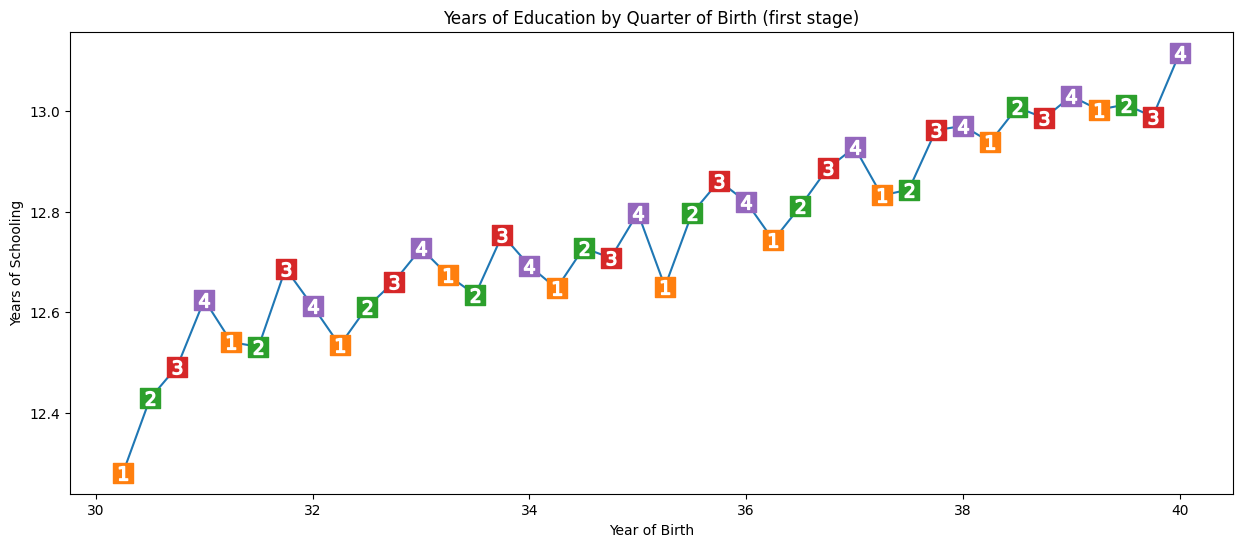

In [11]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

For simplicity, use Q4 (yes/no) as instrument

Regress on years of schooling.

Will again show that this is an instrumental variable - more rigorously than just a plot. Will show us if quarter of birth affects years of schooling, whilst also control for year and stat of birth.

Answer: Yes. On average, 0.1 more years of education than those born in other quarters of year.

In [7]:
first_stage = smf.ols(
    'years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4',
    data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272786678
q4 p-value:,  5.464829416613623e-15


<mark>look at this step and make sure understand:</mark> data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

In [8]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286492089094